In [1]:
%matplotlib inline
import numpy as np
import pyfftw
try:
    from nbodykit.lab import *
    from nbodykit import setup_logging, style
except:
    print('no nbodykit')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy.stats import poisson
from Corrfunc.theory import *
from astropy.cosmology import FlatLambdaCDM
from scipy.ndimage import convolve
from scipy.interpolate import interp1d
from scipy.stats import norm
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
from cosmology_functions import *
from save_matrixA_nooverlap import load_matrixA_slab
from run_solutions import calc_coadded_qs, calc_reduced_M

In [3]:
sim = 'AbacusSummit_base_c000_ph006'

In [4]:
# parameters about the sim
boxsize = 2000.
k0 = 2*np.pi/boxsize
N0 = 6912
N = 1152
Nfiles = 34

In [5]:
z = 0.5
Rf = 2 # Gaussian smoothing
Nmesh = 400
interp_method = 'cic'

In [6]:
kx, ky, kz = calc_k_grid(boxsize, Nmesh)
k2 = (kx**2 + ky**2 + kz**2).clip(1e-6)
dk = 2*np.pi/boxsize
_kbins = np.linspace(0.5*dk, (Nmesh//2+0.5)*dk, int(Nmesh/2)+1)
_k = (k2**0.5).ravel()
_ind = np.argsort(_k)
_arr = np.searchsorted(_k[_ind], _kbins)
_k = (k2**0.5)
del kx, ky, kz, k2

In [7]:
use_nabla2d1 = True
# delta1 bins
bin_edges_d1 = np.linspace(-4, 5, 40+1)
nbins_d1 = len(bin_edges_d1)-1
# nabla2d1 bins
nbins_nabla2d1 = 1
# saved to which folder
folder = 'matrixA'
if use_nabla2d1:
    bin_edges_nabla2d1_percentile = np.array([0, 5, 35, 65, 95, 100])
    nbins_nabla2d1 = len(bin_edges_nabla2d1_percentile)-1
    folder += '_nabla2d1'

In [8]:
path = '/mnt/store2/xwu/AbacusSummit/%s/z%s_tilde_operators_nbody/Rf%.3g/' % (sim, str(z), Rf) + folder
outpath = path+'/nooverlap'

In [9]:
# centers of the bins
d1_bins = np.zeros(nbins_d1)
for i in range(nbins_d1):
    x = np.linspace(bin_edges_d1[i], bin_edges_d1[i+1], 10)
    d1_bins[i] = np.sum(x*norm.pdf(x))/np.sum(norm.pdf(x))

# pdf of the bins
allbins_pdf = norm.cdf(bin_edges_d1[1:]) - norm.cdf(bin_edges_d1[:-1])
frac_inbins = norm.cdf(bin_edges_d1[-1]) - norm.cdf(bin_edges_d1[0])

if use_nabla2d1:
    d1_bins = d1_bins.reshape(nbins_d1,-1) + np.zeros((nbins_d1, nbins_nabla2d1))
    allbins_pdf = allbins_pdf.reshape(-1,1) * \
        (bin_edges_nabla2d1_percentile[1:] - bin_edges_nabla2d1_percentile[:-1]).reshape(1,-1)

    try:
        nabla2d1_bins = np.loadtxt('nabla2d1_bins.txt')
    except:
        # load in the delta1 and only use some
        sdelta1 = np.load('/mnt/store2/xwu/AbacusSummit/%s/ic_%d/sdelta1_Rf%.3g.npy' % (sim, N, Rf))
        sigma_sdelta1 = np.std(sdelta1)
        sdelta1 = sdelta1.reshape(-1)/sigma_sdelta1
        # sort the values
        ind = np.argsort(sdelta1)
        sdelta1 = sdelta1[ind]
        arr = np.searchsorted(sdelta1, bin_edges_d1)

        # load in nabla2d1 and only use some
        nabla2d1 = np.load('/mnt/store2/xwu/AbacusSummit/%s/ic_%d/nabla2d1_Rf%.3g.npy' % (sim, N, Rf))
        sigma_nabla2d1 = np.std(nabla2d1)
        print(np.mean(nabla2d1), sigma_nabla2d1)
        nabla2d1 = nabla2d1.reshape(-1)/sigma_nabla2d1
        nabla2d1 = nabla2d1[ind]

        # calculate nabla2d1 bin centers once and save values
        nabla2d1_bins = np.zeros((nbins_d1, nbins_nabla2d1))
        for m in range(nbins_d1):
            nabla2d1_ = nabla2d1[arr[m]:arr[m+1]]
            bin_edges_nabla2d1 = np.percentile(nabla2d1_, bin_edges_nabla2d1_percentile)
            for n in range(nbins_nabla2d1):
                ii = (nabla2d1_ >= bin_edges_nabla2d1[n]) & (nabla2d1_ < bin_edges_nabla2d1[n+1])
                nabla2d1_bins[m,n] = np.mean(nabla2d1_[ii])

        del sdelta1, nabla2d1, nabla2d1_
        np.savetxt('nabla2d1_bins.txt', nabla2d1_bins, fmt='%.3g')

# calculate pdf of bins
allbins_pdf /= allbins_pdf.sum()
allbins_pdf = allbins_pdf.reshape(-1)

7.072288e-14 0.0035548073


In [10]:
# load in snapshot
cat = CompaSOHaloCatalog('/mnt/store2/bigsims/AbacusSummit/%s/halos/z%.3f/' % (sim, z),
                         fields=['N', 'x_com', 'r100_com'])

### N > 150 halos

In [11]:
# halo grid
# mass weighted
ii_h = (cat.halos['N'] > 150)
delta_h = ArrayCatalog({'Position': cat.halos[ii_h]['x_com'], 'Value': cat.halos[ii_h]['N']}).to_mesh(
    Nmesh=Nmesh, BoxSize=boxsize, resampler=interp_method).compute()
delta_h = delta_h/np.mean(delta_h)-1.
deltak_h = pyfftw.interfaces.numpy_fft.rfftn(delta_h)

In [12]:
# P_shot = boxsize**3/ii_h.sum()
P_shot = f_Pshot_M(boxsize, cat.halos[ii_h]['N'])
kvec, Pk_h = calc_powerspectrum(deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)

#### f as a function of delta1 only

In [15]:
# remove_overlaps=(False, True)

In [13]:
if allbins_pdf.size != nbins_d1:
    tmp = np.zeros(nbins_d1)
    for i in range(nbins_nabla2d1):
        tmp += allbins_pdf[i::nbins_nabla2d1]
    allbins_pdf = tmp

In [14]:
# coadded M and b

# # can sum up the A matrices on the way...
# M_tot, b_tot = calc_coadded_qs(outpath, Nmesh, interp_method,
#                     direct_load=True, sum_nabla2d1_bins=True, nbins_nabla2d1=nbins_nabla2d1,
#                     calc_M=True, delta_hs=delta_h)
# b_tot = b_tot[0]

# or multiply by the "transfer" matrix
M_tot, b_tot = calc_coadded_qs(outpath, Nmesh, interp_method, direct_load=True, calc_M=True, delta_hs=delta_h)
T = np.zeros((nbins_d1*nbins_nabla2d1, nbins_d1))
for i in range(nbins_d1):
    T[i*nbins_nabla2d1:(i+1)*nbins_nabla2d1,i] = 1.
M_tot = np.dot(T.T, np.dot(M_tot, T))
b_tot = np.dot(T.T, b_tot[0])

M_tot_, D, ii_empty = calc_reduced_M(M_tot)

In [18]:
b_tot = np.dot(T.T, b_tot)

1.0135948093675882
1.0122880187574834
1.0137595941800077
1.0119891411266058
1.0132690086528473
1.013905595881914


(-0.1, 10.0)

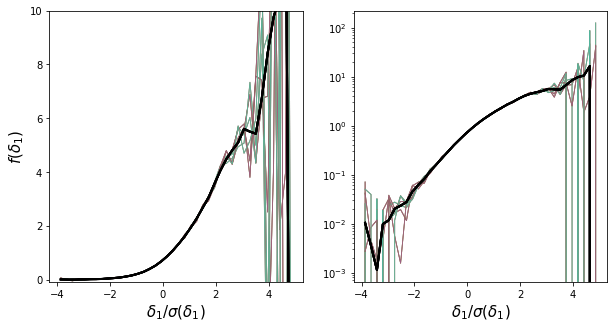

In [20]:
# take a few slabs and calculate a solution for each slab
fig, axes = plt.subplots(figsize=(10,5), nrows=1, ncols=2)

for i in [0, 6, 13, 19, 25, 31]:
    #A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method,
    #                               remove_overlaps=remove_overlaps, direct_load=True)
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method,
        direct_load=True, sum_nabla2d1_bins=True, nbins_nabla2d1=nbins_nabla2d1)
    M = np.dot(A, A.T)
    M_, D, _ = calc_reduced_M(M)

    b = np.dot(A, delta_h[ind_slab].reshape(-1)+1.)

    f_delta1 = np.dot(D, np.dot(np.linalg.inv(M_), b/np.diag(M)**0.5))
    ncell = len(ind_slab)*Nmesh**2
    nparticles = 0.03*N0**3*frac_inbins*len(ind_slab)/Nmesh # this is a rough approximation
    f_delta1 *= nparticles/ncell

    # plot each solution
    axes[0].plot(d1_bins, f_delta1, linewidth=0.8, alpha=0.6)
    axes[1].plot(d1_bins, f_delta1, linewidth=0.8, alpha=0.6)

    # check the solution
    print((allbins_pdf*f_delta1).sum())

axes[0].plot(d1_bins, f_delta1_tot, 'k', linewidth=2)
axes[1].plot(d1_bins, f_delta1_tot, 'k', linewidth=2)

axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[0].set_ylabel(r'$f(\delta_1)$', fontsize=15)
axes[1].set_yscale('log')

axes[0].set_ylim(-0.1, 10)

(-0.1, 10.0)

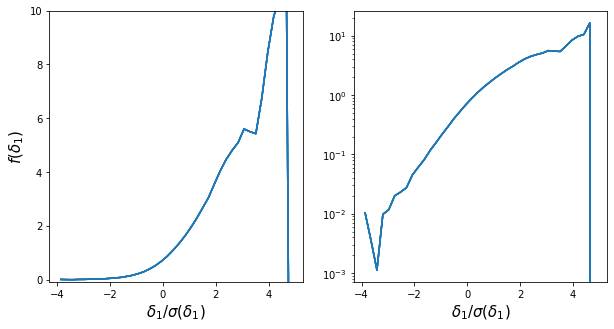

In [20]:
fig, axes = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
axes[0].plot(d1_bins, f_delta1_tot, 'tab:blue')
axes[1].plot(d1_bins, f_delta1_tot, 'tab:blue')
axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[0].set_ylabel(r'$f(\delta_1)$', fontsize=15)
axes[1].set_yscale('log')
axes[0].set_ylim(-0.1, 10)

In [21]:
# check how this works...
delta_model = np.zeros((Nmesh, Nmesh, Nmesh))
f_delta1 = f_delta1_tot
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
for i in range(Nfiles):
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method,
        direct_load=True, sum_nabla2d1_bins=True, nbins_nabla2d1=nbins_nabla2d1)
    delta_model[ind_slab] += np.dot(f_delta1, A).reshape(-1,Nmesh,Nmesh)
delta_model = delta_model/(nparticles/ncell) - 1.
print(np.mean(delta_model))
deltak_model = pyfftw.interfaces.numpy_fft.rfftn(delta_model)

0.012522953851802719


In [22]:
kvec, Pk_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)
Pk_res = calc_powerspectrum(deltak_model-deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
Pk_res_h = calc_powerspectrum(deltak_model-deltak_h, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]

Text(0.5, 0, '$k$')

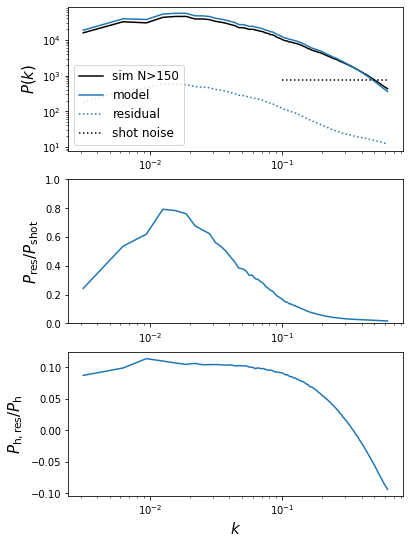

In [26]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, 'k', label='sim N>150')
plt.loglog(kvec, Pk_model, label='model')
plt.loglog(kvec, Pk_res, 'tab:blue', linestyle=':', label='residual')
plt.loglog([0.1, kvec[-1]], [P_shot, P_shot], 'k:', label='shot noise')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot)
plt.ylim(0, 1)
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_res_h/Pk_h)
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

In [24]:
# dividing into the uncorrelated and correlated parts
Pk_h_model = calc_powerspectrum(deltak_model, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]
Pk_alpha = Pk_h_model**2/Pk_h
Pk_eps = Pk_model - Pk_alpha

Text(0.5, 0, '$k$')

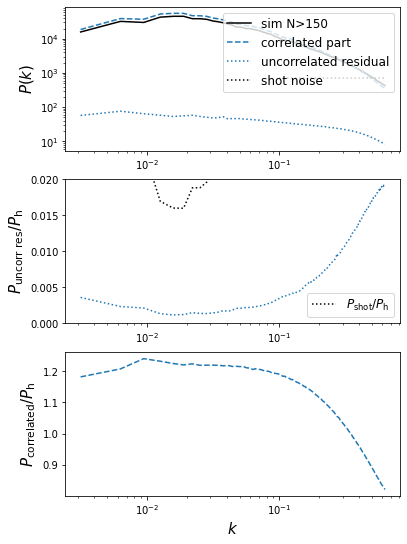

In [25]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, 'k', label='sim N>150')
plt.loglog(kvec, Pk_alpha, '--', label='correlated part')
plt.loglog(kvec, Pk_eps, 'tab:blue', linestyle=':', label='uncorrelated residual')
plt.loglog([0.1, kvec[-1]], [P_shot, P_shot], 'k:', label='shot noise')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12, loc=1)
plt.subplot(312)
plt.semilogx(kvec, Pk_eps/Pk_h, ':')
plt.plot(kvec, P_shot/Pk_h, 'k:', label=r'$P_{\rm shot}/P_{\rm h}$')
plt.legend(fontsize=12)
plt.ylim(0, 0.02)
plt.ylabel(r'$P_{\rm uncorr\ res}/P_{\rm h}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_alpha/Pk_h, '--')
plt.ylabel(r'$P_{\rm correlated}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

##### examinations of the matrix M

In [15]:
ii_empty

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [32]:
np.linalg.cond(M_tot), np.linalg.cond(M_tot_)

(20335291.64058084, 836.8683623874755)

In [17]:
np.linalg.eigvals(M_tot_)

array([12.40937506,  6.3135325 ,  4.52749186,  3.49558491,  2.66373065,
        2.00861829,  1.52324318,  1.15880931,  0.89108091,  0.69803567,
        0.55824402,  0.45586761,  0.38082068,  0.32544785,  0.2853224 ,
        0.25745783,  0.23428593,  0.21235271,  0.19131353,  0.17131174,
        0.15308876,  0.13652886,  0.12168258,  0.10848181,  0.0969116 ,
        0.08690762,  0.07757102,  0.06909722,  0.06103027,  0.05358498,
        0.04679187,  0.04063941,  0.03536705,  0.0307485 ,  0.01482855,
        0.01620654,  0.01809747,  0.02045641,  0.02674506,  0.02330778])

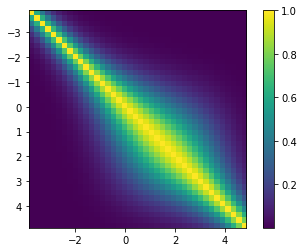

In [18]:
plt.imshow(M_tot_, extent=(d1_bins[0],d1_bins[-1],d1_bins[-1],d1_bins[0]))
plt.colorbar()

#### including nabla2d1

In [15]:
# remove_overlaps=(False, True)

In [34]:
# coadded M and b
M, b = calc_coadded_qs(outpath, Nmesh, interp_method,
                    direct_load=True, calc_M=True, delta_hs=delta_h)
b = b[0]
M_, D, ii_empty = calc_reduced_M(M)

# calculate solution
f_delta1 = np.dot(D, np.dot(np.linalg.inv(M_), b/np.diag(M)**0.5))
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
f_delta1 *= nparticles/ncell
# check the solution
print((allbins_pdf*f_delta1).sum())

0.9929533368160299


In [28]:
# or load from disk
f_delta1 = np.loadtxt('../f(delta1,nabla2d1)_z0.5_Rf%.3g_Nmesh%d.txt' % (Rf, Nmesh))[:,0]
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins

Text(0, 0.5, '$\\nabla^2\\delta_1/\\sigma(\\nabla^2\\delta_1)$')

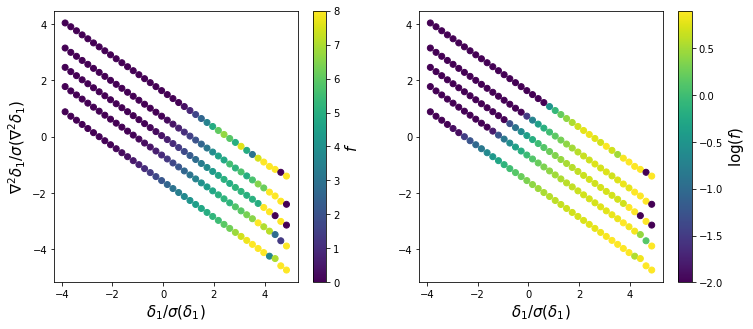

In [15]:
# plot the solution
fig, axes = plt.subplots(figsize=(12,5), nrows=1, ncols=2)

im = axes[0].scatter(d1_bins, nabla2d1_bins, c=f_delta1.clip(0), vmin=0, vmax=8)
cbar = plt.colorbar(im, ax=axes[0])
cbar.set_label(r'$f$', fontsize=15)
im = axes[1].scatter(d1_bins, nabla2d1_bins, c=np.log10(f_delta1.clip(1e-2, 8)))
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label(r'$\log(f)$', fontsize=15)

axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[0].set_ylabel(r'$\nabla^2\delta_1/\sigma(\nabla^2\delta_1)$', fontsize=15)

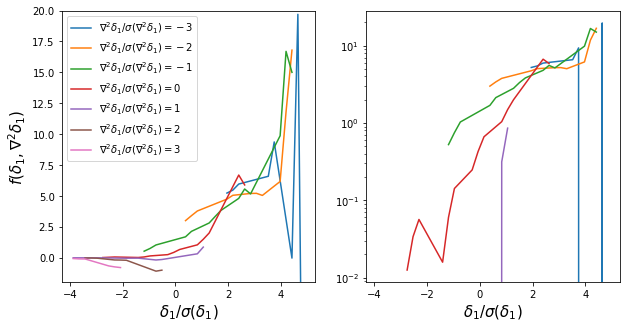

In [21]:
# find a better way of plotting
fig, axes = plt.subplots(figsize=(10,5), nrows=1, ncols=2)
for nabla2d1 in np.arange(-3,4,1):
    ii = np.where(np.abs(nabla2d1_bins - nabla2d1) < 0.2)
    d1_bins_ = d1_bins[ii]
    nabla2d1_ = nabla2d1_bins[ii].mean()
    f_ = f_delta1.reshape(-1,nbins_nabla2d1)[ii]
    axes[0].plot(d1_bins_, f_, label=r'$\nabla^2\delta_1/\sigma(\nabla^2\delta_1)=%.0f$' % nabla2d1_)
    axes[1].plot(d1_bins_, f_)
axes[0].legend()
axes[0].set_ylim(-2, 20)
axes[0].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[1].set_xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
axes[0].set_ylabel(r'$f(\delta_1,\nabla^2\delta_1)$', fontsize=15)
axes[1].set_yscale('log')

Text(0, 0.5, '$f(\\delta_1,\\nabla^2\\delta_1)$')

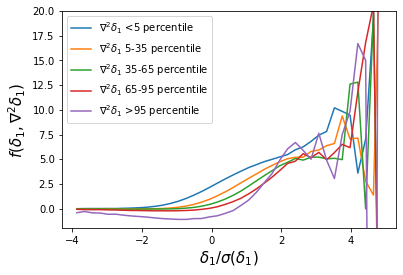

In [26]:
# or plot the diagonal lines
for i in range(nbins_nabla2d1):
    if i == 0:
        label = '<%d percentile' % bin_edges_nabla2d1_percentile[1]
    elif i == nbins_nabla2d1-1:
        label = '>%d percentile' % bin_edges_nabla2d1_percentile[-2]
    else:
        label = '%d-%d percentile' % (bin_edges_nabla2d1_percentile[i],bin_edges_nabla2d1_percentile[i+1])
    plt.plot(d1_bins[:,0], f_delta1[i::nbins_nabla2d1],
        label=r'$\nabla^2\delta_1$ '+label)
plt.legend()
plt.ylim(-2, 20)
plt.xlabel(r'$\delta_1/\sigma(\delta_1)$', fontsize=15)
plt.ylabel(r'$f(\delta_1,\nabla^2\delta_1)$', fontsize=15)

In [29]:
# check how this works...
delta_model = np.zeros((Nmesh, Nmesh, Nmesh))
for i in range(Nfiles):
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method, direct_load=True)
    delta_model[ind_slab] += np.dot(f_delta1, A).reshape(-1,Nmesh,Nmesh)
delta_model = delta_model/(nparticles/ncell) - 1.
print(np.mean(delta_model))
deltak_model = pyfftw.interfaces.numpy_fft.rfftn(delta_model)

-0.007018548463123686


In [37]:
kvec, Pk_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)
Pk_res = calc_powerspectrum(deltak_model-deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
Pk_res_h = calc_powerspectrum(deltak_model-deltak_h, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]

Text(0.5, 0, '$k$')

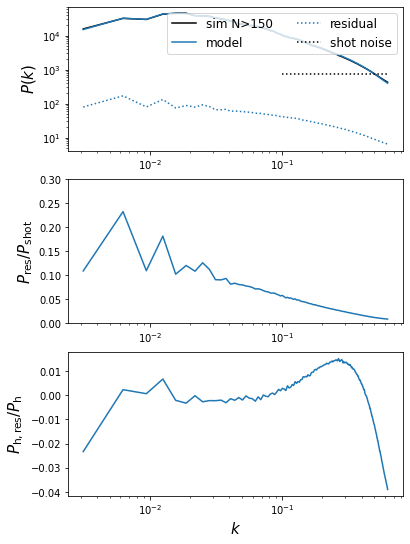

In [38]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, 'k', label='sim N>150')
plt.loglog(kvec, Pk_model, label='model')
plt.loglog(kvec, Pk_res, 'tab:blue', linestyle=':', label='residual')
plt.loglog([0.1, kvec[-1]], [P_shot, P_shot], 'k:', label='shot noise')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12, loc=1, ncol=2)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot)
plt.ylim(0, 0.3)
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_res_h/Pk_h)
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

In [32]:
# dividing into the uncorrelated and correlated parts
Pk_h_model = calc_powerspectrum(deltak_model, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]
Pk_alpha = Pk_h_model**2/Pk_h
Pk_eps = Pk_model - Pk_alpha

Text(0.5, 0, '$k$')

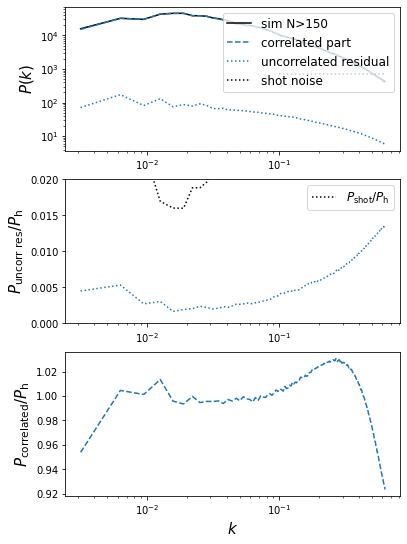

In [33]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, 'k', label='sim N>150')
plt.loglog(kvec, Pk_alpha, '--', label='correlated part')
plt.loglog(kvec, Pk_eps, 'tab:blue', linestyle=':', label='uncorrelated residual')
plt.loglog([0.1, kvec[-1]], [P_shot, P_shot], 'k:', label='shot noise')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12, loc=1)
plt.subplot(312)
plt.semilogx(kvec, Pk_eps/Pk_h, ':')
plt.plot(kvec, P_shot/Pk_h, 'k:', label=r'$P_{\rm shot}/P_{\rm h}$')
plt.legend(fontsize=12)
plt.ylim(0, 0.02)
plt.ylabel(r'$P_{\rm uncorr\ res}/P_{\rm h}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_alpha/Pk_h, '--')
plt.ylabel(r'$P_{\rm correlated}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

##### examinations of the matrix M

In [24]:
ii_empty

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [25]:
np.linalg.cond(M), np.linalg.cond(M_)

(541642993.4383168, 1598.2064617939307)

In [26]:
np.linalg.eigvals(M_)

array([3.77916924e+01, 1.82567770e+01, 1.21312808e+01, 9.00202381e+00,
       7.02183643e+00, 5.63432789e+00, 4.56135241e+00, 3.77329071e+00,
       3.48328789e+00, 3.42244192e+00, 3.08968543e+00, 2.91764780e+00,
       2.75475343e+00, 2.61777916e+00, 2.41468601e+00, 2.30945828e+00,
       2.09958259e+00, 2.04060061e+00, 1.96619250e+00, 1.82341428e+00,
       1.79683195e+00, 1.67519613e+00, 1.63923162e+00, 1.57024824e+00,
       1.53383005e+00, 1.42269389e+00, 1.35913145e+00, 1.30238791e+00,
       1.24975411e+00, 1.22903329e+00, 1.19436825e+00, 1.14186876e+00,
       1.09582482e+00, 1.08182091e+00, 1.05258026e+00, 9.97652748e-01,
       9.59427334e-01, 9.23976583e-01, 9.13213103e-01, 8.71452501e-01,
       8.66328590e-01, 8.18239464e-01, 8.16635318e-01, 7.83361070e-01,
       7.66663806e-01, 7.61379490e-01, 7.33236614e-01, 7.13800881e-01,
       7.06752273e-01, 6.91624292e-01, 6.40842198e-01, 6.51500374e-01,
       6.60247393e-01, 6.35296761e-01, 6.13210463e-01, 6.04925967e-01,
      

### use the density field as a test

In [13]:
delta_h = BigFileMesh(
    '/mnt/store2/xwu/AbacusSummit/base_c000_ph006/z%s_tilde_operators_nbody/deltaz_Nmesh%d_cic.bigfile'
    % (str(z), Nmesh), 'Field').compute()-1.
deltak_h = pyfftw.interfaces.numpy_fft.rfftn(delta_h)

In [14]:
P_shot = boxsize**3/(0.03*N0**3)
kvec, Pk_h = calc_powerspectrum(deltak_h, boxsize, ind=_ind, arr=_arr, kbins=_kbins)

In [15]:
b_tot = calc_coadded_b(delta_h, outpath, Nmesh, interp_method, direct_load=True)
b = b_tot

In [16]:
f_delta1 = np.dot(D, np.dot(np.linalg.inv(M_), b/np.diag(M)**0.5))
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
f_delta1 *= nparticles/ncell
# check the solution
print((allbins_pdf*f_delta1).sum())

f_delta1_tot = f_delta1

0.9999847672120652


In [17]:
# check how this works...
delta_model = np.zeros((Nmesh, Nmesh, Nmesh))
f_delta1 = f_delta1_tot
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
for i in range(Nfiles):
    #A, ind_slab = load_matrixA_slab(i, path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method, direct_load=True)
    delta_model[ind_slab] += np.dot(f_delta1, A).reshape(-1,Nmesh,Nmesh)
delta_model = delta_model/(nparticles/ncell) - 1.
print(np.mean(delta_model))
deltak_model = pyfftw.interfaces.numpy_fft.rfftn(delta_model)

-7.929166354451674e-06

In [18]:
kvec, Pk_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)
Pk_res = calc_powerspectrum(deltak_h-deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
Pk_res_h = calc_powerspectrum(deltak_h-deltak_model, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]

Text(0.5, 0, '$k$')

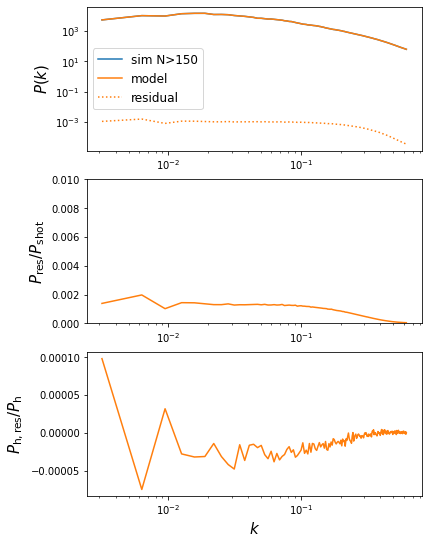

In [19]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, label='sim')
plt.loglog(kvec, Pk_model, label='model')
plt.loglog(kvec, Pk_res, 'tab:orange', linestyle=':', label='residual')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot, 'tab:orange')
plt.ylim(0, 0.01)
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_res_h/Pk_h, 'tab:orange')
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

In [20]:
# what if I input all ones
delta_model = np.zeros((Nmesh, Nmesh, Nmesh))
f_delta1 = f_delta1_tot
ncell = Nmesh**3
nparticles = 0.03*N0**3*frac_inbins
for i in range(Nfiles):
    #A, ind_slab = load_matrixA_slab(i, path, Nmesh, interp_method, remove_overlaps=remove_overlaps)
    #A, ind_slab = As[i], ind_slabs[i]
    A, ind_slab = load_matrixA_slab(i, outpath, Nmesh, interp_method, direct_load=True)
    delta_model[ind_slab] += np.dot(np.ones_like(f_delta1), A).reshape(-1,Nmesh,Nmesh)
delta_model = delta_model/(nparticles/ncell) - 1.
print(np.mean(delta_model))
deltak_model = pyfftw.interfaces.numpy_fft.rfftn(delta_model)

7.710403207193581e-06

In [21]:
kvec, Pk_model = calc_powerspectrum(deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)
Pk_res = calc_powerspectrum(deltak_h-deltak_model, boxsize, ind=_ind, arr=_arr, kbins=_kbins)[1]
Pk_res_h = calc_powerspectrum(deltak_h-deltak_model, boxsize, grid2=deltak_h, ind=_ind, arr=_arr, kbins=_kbins)[1]

Text(0.5, 0, '$k$')

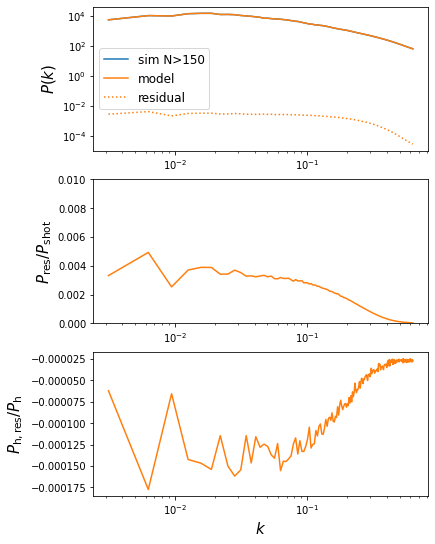

In [22]:
plt.figure(figsize=(6,9))
plt.subplot(311)
plt.loglog(kvec, Pk_h, label='sim')
plt.loglog(kvec, Pk_model, label='model')
plt.loglog(kvec, Pk_res, 'tab:orange', linestyle=':', label='residual')
plt.ylabel(r'$P(k)$', fontsize=15)
plt.legend(fontsize=12)
plt.subplot(312)
plt.semilogx(kvec, Pk_res/P_shot, 'tab:orange')
plt.ylim(0, 0.01)
plt.ylabel(r'$P_{\rm res}/P_{\rm shot}$', fontsize=15)
plt.subplot(313)
plt.semilogx(kvec, Pk_res_h/Pk_h, 'tab:orange')
plt.ylabel(r'$P_{\rm h, res}/P_{\rm h}$', fontsize=15)
plt.xlabel(r'$k$', fontsize=15)

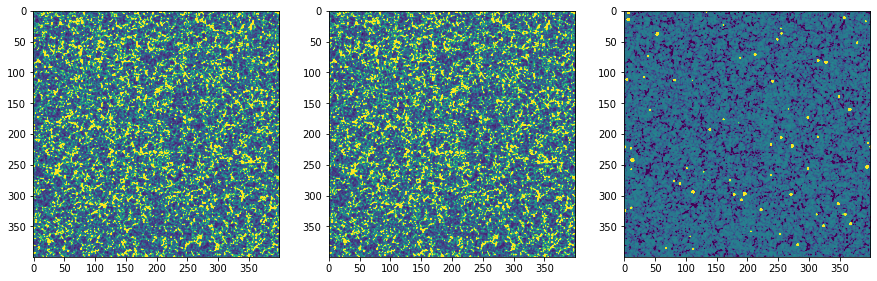

In [23]:
tmp1 = delta_h[:,:,100]
tmp2 = delta_model[:,:,100]
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(tmp1, vmin=-1, vmax=1)
plt.subplot(132)
plt.imshow(tmp2, vmin=-1, vmax=1)
plt.subplot(133)
plt.imshow(tmp1-tmp2, vmin=-1e-4, vmax=1e-4)